In [452]:
# Define your model

import torchvision.models as models
from efficientnet_pytorch import EfficientNet
import torchvision.models as models

# model = models.densenet121(pretrained=True).eval()
model = models.resnet18(pretrained=True).eval()
# model = models.resnet34(pretrained=True).eval()
# model = models.inception_v3(pretrained=True)
# model = EfficientNet.from_pretrained('efficientnet-b0').eval()


c:\Users\mi\scoop\apps\anaconda3\2024.02-1\App\envs\DigitalNumber\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mi\scoop\apps\anaconda3\2024.02-1\App\envs\DigitalNumber\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [453]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
from torchcam.methods import GradCAMpp
import torch

# Get your input
img = read_image("image/1dog.jpg")
# Preprocess it for your chosen model
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# dog_index = 207

with GradCAMpp(model) as cam_extractor:
    out = model(input_tensor.unsqueeze(0))
    
    # 获取最可能的类别
    match_index = out.squeeze(0).argmax().item()
    print(f'Model predicted class index: {match_index}')
    
    # 获取前3个最大值及其索引
    topk_values, topk_indices = torch.topk(out.squeeze(0), k=2)
    top5_indices = topk_indices.tolist()
    print(f"Top 5 class indices: {top5_indices}")

    top5_indices[0] = 208
    top5_indices[1] = 281
    # 提取激活图并合并
    activation_maps = []
    for index in top5_indices:
        activation_map = cam_extractor(index, out, retain_graph=True)[0]  # 提取每个类别的激活图
        activation_maps.append(activation_map)


    # 定义权重并归一化
    weights = torch.tensor([1, 1], dtype=torch.float32)
    weights /= weights.sum()

    # 加权合并激活图
    weighted_activation_map = sum(weight * activation_map for weight, activation_map in zip(weights, activation_maps))
    combined_activation_map = weighted_activation_map

# 之后可以使用 combined_activation_map 进行进一步处理

# with GradCAMpp(model) as cam_extractor:
#     out = model(input_tensor.unsqueeze(0))
#     match_index = out.squeeze(0).argmax().item()
#     activation_map = cam_extractor(281, out)
#     print(match_index)


Model predicted class index: 273
Top 5 class indices: [273, 231]


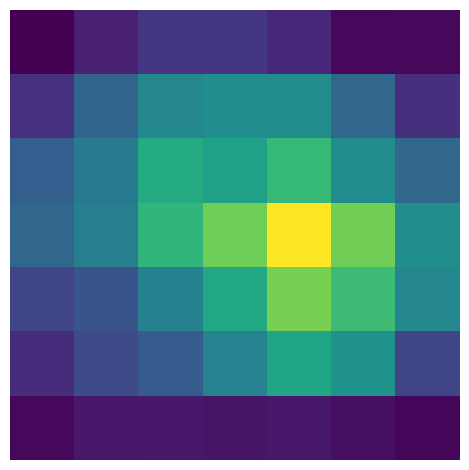

In [454]:
import matplotlib.pyplot as plt
# Visualize the raw CAM
plt.imshow(activation_map[0].squeeze(0).numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

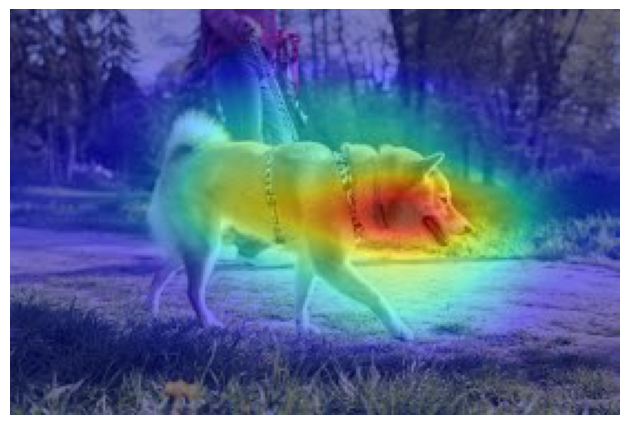

In [455]:
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask

# Resize the CAM and overlay it

result = overlay_mask(to_pil_image(img), to_pil_image(combined_activation_map[0].squeeze(0), mode='F'), alpha=0.5)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()